In [199]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#os.chdir('G:\sources\AI_based_SE\AISE_fooling')

import torch
import random
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import random

#from model import Model

import torch
print(torch.__version__)

1.9.0+cu102


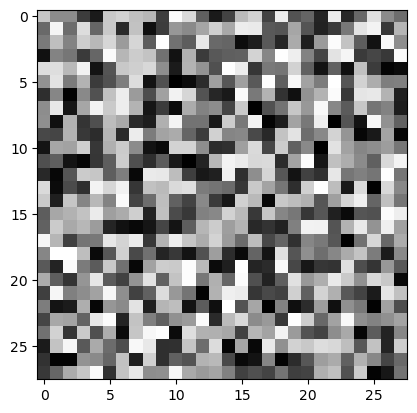

In [201]:
def show_image(arr):
    if 'cuda' in str(arr.device):
        arr = arr.cpu()
    plt.imshow(arr, cmap='gray')
    plt.show()

# TEST
# CUDA
# size = (28,28)
# a = torch.rand(size).cuda()
# show_image(a)

# CPU
a = torch.rand(size)
show_image(a)

In [202]:
def recovery_image(arr):
    rand_num = torch.rand((28,28))/4

    d = c[0][0] + rand_num
    d[d<1/4] = 0

    return torch.reshape(d, (1,1,28,28))
    show_image(d)

In [203]:
def normalize(value):
    return value * 4 // 1 / 4

In [205]:
model_path = '/mnt/g/sources/AI_based_SE/AISE_fooling/models/mnist_0.9893.pkl'
model = torch.load(model_path)
#model_cuda = torch.load(model_path).cuda()

In [206]:
def generate_initial_image(norm=False, cuda=False, size=(28,28), batch_size=1):
    if cuda:
        image_arr = torch.rand(batch_size, size[0], size[1]).cuda()
    else:
        image_arr = torch.rand(batch_size, size[0], size[1])

    if norm:
        image_arr = normalize(image_arr) # * 4 // 1 / 4
    
    #image_arr = image_arr.unsqueeze(0).unsqueeze(0)
    return image_arr

if True:
    # CPU
    print(generate_initial_image(norm=True, cuda=False, size=(2,2), batch_size=2))
    
    # CUDA
    #print(generate_initial_image(norm=True, cuda=True, size=(2,2), batch_size=2))

tensor([[[0.2500, 0.5000],
         [0.7500, 0.0000]],

        [[0.5000, 0.5000],
         [0.5000, 0.2500]]])


In [207]:
def polynomial_mutate(value, cuda=False):
    strength = 15

    if cuda:
        u = torch.rand(value.shape).cuda()
        delta = torch.zeros(value.shape).cuda()
    else:
        u = torch.rand(value.shape)
        delta = torch.zeros(value.shape)

    delta[u<0.5] = (pow((u[u<0.5] * 2), (1.0 / strength + 1.0))) - 1
    delta[u>=0.5] = 1 - pow(2.0 * (1.0 - u[u>=0.5]), 1.0 / (strength + 1.0))
    
#     if u < 0.5:
#         delta = (pow((u * 2), (1.0 / strength + 1.0))) - 1
#     else:
#         delta = 1 - pow(2.0 * (1.0 - u), 1.0 / (strength + 1.0))

    delta[delta<0] = 0
    delta[delta>1] = 1
    
    result = value + delta
    return result

# TEST
if True:
    batch_size = 64
    size = (28,28)
    # CUDA
#     a = torch.rand((batch_size, size[0], size[1]))#.cuda();
#     for i in range(5):
#         a = polynomial_mutate(a, cuda=True)
#         print(a[0][0][0])

    # CPU
    a = torch.rand((batch_size, size[0], size[1]));
    for i in range(5):
        a = polynomial_mutate(a, cuda=False)
        print(a[0][0][0])

tensor(0.9786)
tensor(1.0504)
tensor(1.0504)
tensor(1.0504)
tensor(1.0504)


In [208]:
def mutate(image_arr, mutate_rate, mutate_type='poly', norm=False, cuda=False, size=(28,28), batch_size=1):
    image_flatten = torch.reshape(image_arr, (batch_size * size[0] * size[1], 1))
    num_change = int(batch_size * size[0] * size[1] * mutate_rate)
    prob = torch.rand((batch_size * size[0] * size[1]))
    change_idx = torch.multinomial(prob, num_samples=num_change)
    
    #print(change_idx.shape)
    #print(image_flatten[change_idx].shape)
    
    image_flatten[change_idx] = polynomial_mutate(image_flatten[change_idx], cuda=cuda)
    
    image_arr = torch.reshape(image_flatten, (batch_size, size[0], size[1]))    
    
#     for i in range(batch_size):
#         prob = torch.rand(size)
#         change_idx[i] = torch.multinomial(prob, num_samples=num_change)
    
#         if mutate_type == "poly":
#             image_arr[change_idx] = polynomial_mutate(image_arr[i][change_idx[i]], cuda=cuda)
#         else: # uniform
#             image_arr[i][change_idx] = uniform_mutate(image_arr[i][change_idx[i]], cuda=cuda)
#             if cuda:
#                 image_arr[i][change_idx] = torch.rand(image_arr[i][change_idx[i]].shape).cuda()
#             else:
#                 image_arr[i][change_idx] = torch.rand(image_arr[i][change_idx[i]].shape)
    
#     for i in range(size[0]):
#         for j in range(size[1]):
#             if mutate_type == "poly":
#                 image_arr[i][j] = polynomial_mutate(image_arr[i][j], norm, cuda=cuda)
#             else:
#                 if cuda:
#                     if torch.rand([1]).cuda()[0] < rate:
#                         image_arr[i][j] = torch.rand([1]).cuda()
#                 else:
#                     if torch.rand([1])[0] < rate:
#                         image_arr[i][j] = torch.rand([1])
                    
#             if norm:
#                 image_arr = normalize(image_arr)
    return image_arr

# TEST
if True:
    batch_size = 64
    size = (28,28)
    
    # CUDA
    #a = torch.zeros(batch_size, size[0], size[1]).cuda()
    #print(mutate(a, 0.1, norm=False, cuda=True, size=size, batch_size=batch_size))
    
    # CPU
    a = torch.zeros(batch_size, size[0], size[1])
    print(a.shape)
    print(len(a[a!=0]))
    
    b = mutate(a, 0.1, norm=False, cuda=False, size=size, batch_size=batch_size)
    print(b.shape)
    print(len(b[b!=0]))

torch.Size([64, 28, 28])
0
torch.Size([64, 28, 28])
2480


In [209]:
# TODO : 추가해야할 것 확인 및 코딩
# SBX(Simulated Binary Crossover) crossover

def crossover():
    print("crossover")

torch.Size([64])
precision : tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1905, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 3.1624, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0866, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1094, 0.0000, 0.0000, 0.0000, 0.2336, 0.0000, 0.4677,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<SelectBackward>)


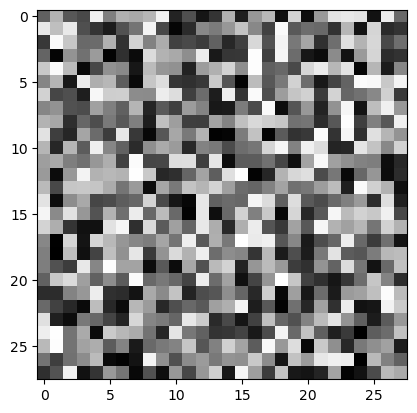

In [210]:
def fitness_function(image_arr, label, cuda=False):
    image_arr = image_arr.unsqueeze(1)
    
    if cuda:
        predict_y = model_cuda(image_arr.float())
    else:
        predict_y = model(image_arr.float())

    return predict_y[:,label]

# TEST
if True:
    label=1
    batch_size = 64

    # CUDA
#     a = generate_initial_image(cuda=True)
#     y = fitness_function(a, 0, cuda=True)
#     show_image(a)
    
    # CPU
    a = generate_initial_image(cuda=False, batch_size=batch_size)
    y = fitness_function(a, label, cuda=False)
    print(y.shape)
    print(f"precision : {y}")
    show_image(a[0])

In [211]:
def get_update_batches(batch_score, max_change=10, ):
    sorted_score, sorted_index = batch_score.sort()
    
    sorted_score = sorted_score[-max_change:]
    sorted_index = sorted_index[-max_change:]
    
    a = sorted_score!=0.0
    sorted_score = sorted_score[a]
    sorted_index = sorted_index[a]
    
    return sorted_score, sorted_index

In [212]:
def get_lowest_batches(image_arr, choice_num):
    sorted_score, sorted_index = image_arr.sort()
    sorted_index = sorted_index[:choice_num]
    return sorted_index

#TEST
if True:
    a = list(range(10))
    random.shuffle(a)
    a = torch.tensor(a)
    a_idx = get_lowest_batches(a, 3)
    print(a)
    print("idx :\t", a_idx)
    print("value :\t", a[a_idx])

tensor([7, 2, 5, 6, 0, 8, 4, 1, 3, 9])
idx :	 tensor([4, 7, 1])
value :	 tensor([0, 1, 2])


Best score : 99.87417602539062	:   5%|▌         | 1012/20000 [00:07<02:16, 138.85it/s]


best_score : 100.32131958007812


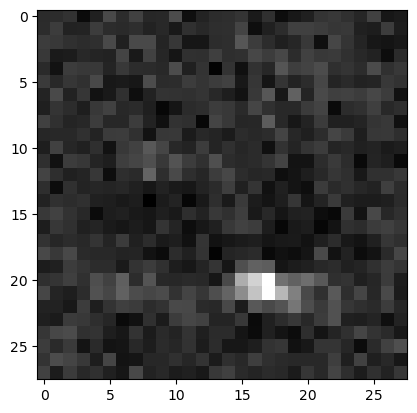

In [213]:
# Mycode 

cuda = False
# cuda = True

iteration = 20000

batch_size = 64

mutate_rate = 0.1
mutate_rate_cutting_time = 1000

max_score = 0

best_image_arr = None
best_score = 0

#label = list(range(0,10))
label = 1

image_arr_batch = generate_initial_image(cuda=cuda, batch_size=batch_size)
image_arr_score = torch.zeros(batch_size)

t = trange(iteration, leave=True)
for i in t:
    t.set_description(f'Best score : {max_score}\t')
    t.refresh() # to show immediately the update
    if i == mutate_rate_cutting_time:
        mutate_rate = mutate_rate / 2
        
    # Mutate
    image_arr_batch_new = mutate(image_arr_batch, mutate_rate, norm=True, cuda=cuda, batch_size=batch_size)
    
    # Fitness & sampling
    batch_score = fitness_function(image_arr_batch_new, label, cuda=cuda)
    update_batch_score, update_batch_index = get_update_batches(batch_score)
    
    # Get updated batches
    candidate_num = len(update_batch_score)
    lowest_indices = get_lowest_batches(image_arr_score, candidate_num)
    
    # Update batches
    image_arr_batch[lowest_indices] = image_arr_batch_new[update_batch_index]
    image_arr_score[lowest_indices] = update_batch_score
    
    # Get max score
    max_idx = torch.argmax(update_batch_score)
    max_score = update_batch_score[max_idx]
    
    if max_score > 99.99:
        best_image_arr = image_arr_batch[max_idx]
        best_score = max_score
        break

print(f'best_score : {best_score}')
show_image(best_image_arr)

In [214]:
best_image_arr = best_image_arr.unsqueeze(0).unsqueeze(0)
y = model(best_image_arr)
print(y)

tensor([[ 0.0000, 99.4668, 58.8541,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]], grad_fn=<ReluBackward0>)
